# Validity of using prescription records to identify patient comorbidities
## Combined Analysis of COPD

**ReadMe:**
- This is a script used in the analysis for Schnier et al., 2025: Validity of using prescription records to classify disease – a record linkage study using routinely collected electronic health records from the UK.
- The underlying data set has been created using the Optimum Patient Care Research Database (https://opcrd.optimumpatientcare.org/). The authors do not have permission to give the public access to the study dataset; researchers may request access to OPCRD for their own purposes. 
 - All code is run in StataSE 18. 


**Set up:**
|Var|Input|
| --- | --- | 
|population|425,000|
|diagnostic codes|Jenni Quint|
|drug codes|Jenni Quint (excluding antibiotics)|
|sql date|25.06.2025|
|sql code|copdselection_20250622.sql| 

In [2]:
    clear all

### Import from SQL server and data wrangling

In [3]:
odbc load, exec("select * from [copd_425000_20250622]") dsn("sqlserverconnect")

In [4]:
generate test=0 if missing(drug_dt)
replace test=1 if ! missing(drug_dt)  

generate diag=0 if missing(diag_dt)
replace diag=1 if ! missing(diag_dt)  

gen start_year=year(fu_start_dt)


egen agecat = cut(age), at(16,30,70,120)
label def agecat_lab 16 "Young" 30 "0Middle" 70 "Elderly" 120 "weird"
label values agecat agecat_lab

egen yearcat = cut(start_year), at(2004,2010,2016,2025)
label def yearcat_lab 2004 "2004-2009" 2010 "2010-2015" 2016 "2016-2020" 
label values yearcat yearcat_lab

egen imdcat = cut(imd_decile), at(0,4,8,11)
label def imdcat_lab 0 "1-3" 4 "4-7" 8 "8-10" 
label values imdcat imdcat_lab


replace bnf_code = "Adrenoreceptor agonist" if bnf_code== "030101"
replace bnf_code = "Antimuscarinic Bronchodilator" if bnf_code== "030102"
replace bnf_code = "Theophylline" if bnf_code== "030103"
replace bnf_code = "Compound bronchodilator" if bnf_code== "030104"
replace bnf_code = "Devices" if bnf_code== "030105" | bnf_code=="210102" | bnf_code=="211200"
replace bnf_code = "Corticosteroids" if bnf_code== "030200"
replace bnf_code = "Topical nasal decongestance" if bnf_code== "120202"
replace bnf_code = "Other/unknown" if missing(bnf_code) & ! missing(drug_dt)
replace bnf_code = "OCT" if bnf_code== "060302"



replace ethnicity="0white" if ethnicity=="1"
replace ethnicity="Other" if ethnicity=="2"
replace ethnicity="Other" if ethnicity=="3"
replace ethnicity="Other" if ethnicity=="4"
replace ethnicity="Other" if ethnicity=="5"
replace ethnicity="Missing" if ethnicity=="99"


encode bnf_code, generate(bnf_code_values) 
encode description, generate(description_values)
encode ethnicity, generate(ethnicity_values) 

gen diag_neg=diag==0
gen diag_pos=diag==1
encode region_name, generate(region) label(regionlbl)
encode ethnicity, generate(ethnic)


(74,041 missing values generated)
(74,041 real changes made)
(16,642 missing values generated)
(16,642 real changes made)
(2,589 missing values generated)
variable bnf_code was str6 now str22
(37,555 real changes made)
variable bnf_code was str22 now str29
(3,297 real changes made)
(207 real changes made)
(909 real changes made)
(0 real changes made)
(17,335 real changes made)
(0 real changes made)
(597 real changes made)
variable ethnicity was str2 now str6
(257,981 real changes made)
(3,762 real changes made)
(23,912 real changes made)
(7,430 real changes made)
(8,764 real changes made)
variable ethnicity was str6 now str7
(123,151 real changes made)


(bin=19, start=16, width=5)


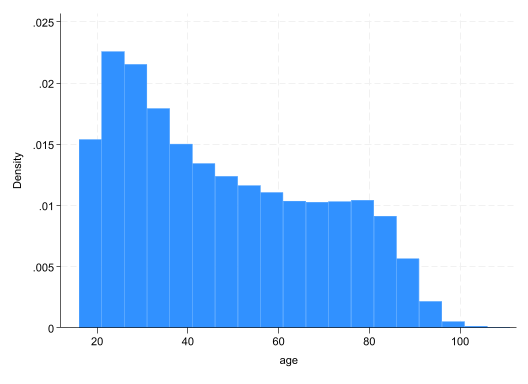

In [5]:
histogram age, width(5)


This table holds one randomly selected diagnostic code found during the observation period. The table is truncated to only include diagnostic codes with a count of 10 or more.

In [6]:
set linesize 132
groups description , select(f >= 10) ord(h) table 


  +-----------------------------------------------------------------------------------------------------+
  |                                                               description   Freq.   Percent     %<= |
  |-----------------------------------------------------------------------------------------------------|
  |                       Chronic obstructive pulmonary disease annual review    2346     14.10   14.10 |
  |                       chronic obstructive pulmonary disease annual review    2321     13.95   28.04 |
  |                     other specified chronic obstructive pulmonary disease    2129     12.79   40.84 |
  |                                               chr. airway obstruction nos    1819     10.93   51.77 |
  |                 acute exacerbation of chronic obstructive airways disease     956      5.74   57.51 |
  |-----------------------------------------------------------------------------------------------------|
  |               chronic obstructive pulmona

These tables holds one randomly selected prescrption during the observation period. The table is truncated to only include codes with a count of 10 or more.


In [7]:
set linesize 132
groups bnf_code , select(f >= 10) ord(h) table 


  +---------------------------------------------------------+
  |                      bnf_code   Freq.   Percent     %<= |
  |---------------------------------------------------------|
  |        Adrenoreceptor agonist   37555     50.72   50.72 |
  |               Corticosteroids   17335     23.41   74.13 |
  |                        060302   14136     19.09   93.23 |
  | Antimuscarinic Bronchodilator    3297      4.45   97.68 |
  |       Compound bronchodilator     909      1.23   98.91 |
  |---------------------------------------------------------|
  |                 Other/unknown     597      0.81   99.71 |
  |                  Theophylline     207      0.28   99.99 |
  +---------------------------------------------------------+


### Results
#### Overall

In [8]:
diagt diag test


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    15,545      1,097 |    16,642 
    Normal |    58,496    349,862 |   408,358 
-----------+----------------------+----------
     Total |    74,041    350,959 |   425,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.9%      3.9%       4.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.4%     93.0%     93.8%
Specificity                      Pr(-|N)     85.7%     85.6%     85.8%
ROC area               (Sens. + Spec.)/2      0.90      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.52      6.

#### Males

In [9]:
diagt diag test if sex==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     8,359        614 |     8,973 
    Normal |    23,977    175,335 |   199,312 
-----------+----------------------+----------
     Total |    32,336    175,949 |   208,285 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.3%      4.2%       4.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.2%     92.6%     93.7%
Specificity                      Pr(-|N)     88.0%     87.8%     88.1%
ROC area               (Sens. + Spec.)/2      0.91      0.90      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      7.74      7.

#### Females

In [10]:
diagt diag test if sex==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     7,186        483 |     7,669 
    Normal |    34,518    174,519 |   209,037 
-----------+----------------------+----------
     Total |    41,704    175,002 |   216,706 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.5%      3.5%       3.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.7%     93.1%     94.2%
Specificity                      Pr(-|N)     83.5%     83.3%     83.6%
ROC area               (Sens. + Spec.)/2      0.89      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.67      5.

#### Age
*16-29*

In [11]:
diagt diag test if agecat==16


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |        59         31 |        90 
    Normal |    12,924    104,660 |   117,584 
-----------+----------------------+----------
     Total |    12,983    104,691 |   117,674 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.1%      0.1%       0.1%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     65.6%     54.8%     75.3%
Specificity                      Pr(-|N)     89.0%     88.8%     89.2%
ROC area               (Sens. + Spec.)/2      0.77      0.72      0.82 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.96      5.

*30-69*

In [12]:
diagt diag test if agecat==30


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     6,805        497 |     7,302 
    Normal |    30,591    183,502 |   214,093 
-----------+----------------------+----------
     Total |    37,396    183,999 |   221,395 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.3%      3.2%       3.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.2%     92.6%     93.8%
Specificity                      Pr(-|N)     85.7%     85.6%     85.9%
ROC area               (Sens. + Spec.)/2      0.89      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.52      6.

In [13]:
diagt diag test if agecat==70


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     8,681        569 |     9,250 
    Normal |    14,981     61,700 |    76,681 
-----------+----------------------+----------
     Total |    23,662     62,269 |    85,931 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)     10.8%     10.6%      11.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.8%     93.3%     94.3%
Specificity                      Pr(-|N)     80.5%     80.2%     80.7%
ROC area               (Sens. + Spec.)/2      0.87      0.87      0.87 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.80      4.

#### Year at start of oberservation period 
*2004-2009*

In [14]:
diagt diag test if yearcat==2004


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     6,104        463 |     6,567 
    Normal |    21,456    121,977 |   143,433 
-----------+----------------------+----------
     Total |    27,560    122,440 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.4%      4.3%       4.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.9%     92.3%     93.6%
Specificity                      Pr(-|N)     85.0%     84.9%     85.2%
ROC area               (Sens. + Spec.)/2      0.89      0.89      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.21      6.

*2010-2015*

In [15]:
diagt diag test if yearcat==2010


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     5,401        346 |     5,747 
    Normal |    20,941    123,312 |   144,253 
-----------+----------------------+----------
     Total |    26,342    123,658 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.8%      3.7%       3.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.0%     93.3%     94.6%
Specificity                      Pr(-|N)     85.5%     85.3%     85.7%
ROC area               (Sens. + Spec.)/2      0.90      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.47      6.

*2016-2020*

In [16]:
diagt diag test if yearcat==2016


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     4,040        288 |     4,328 
    Normal |    16,099    104,573 |   120,672 
-----------+----------------------+----------
     Total |    20,139    104,861 |   125,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.5%      3.4%       3.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.3%     92.6%     94.1%
Specificity                      Pr(-|N)     86.7%     86.5%     86.9%
ROC area               (Sens. + Spec.)/2      0.90      0.90      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      7.00      6.

#### IMD of practice
*1-3*

In [17]:
diagt diag test if imdcat==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     6,202        439 |     6,641 
    Normal |    20,456    127,454 |   147,910 
-----------+----------------------+----------
     Total |    26,658    127,893 |   154,551 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.3%      4.2%       4.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.4%     92.8%     94.0%
Specificity                      Pr(-|N)     86.2%     86.0%     86.3%
ROC area               (Sens. + Spec.)/2      0.90      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.75      6.

*4-7*

In [18]:
diagt diag test if imdcat==4


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     5,391        322 |     5,713 
    Normal |    20,800    116,532 |   137,332 
-----------+----------------------+----------
     Total |    26,191    116,854 |   143,045 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.0%      3.9%       4.1%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.4%     93.7%     94.9%
Specificity                      Pr(-|N)     84.9%     84.7%     85.0%
ROC area               (Sens. + Spec.)/2      0.90      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.23      6.

*8-10*

In [19]:
diagt diag test if imdcat==8


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,926        336 |     4,262 
    Normal |    17,031    103,522 |   120,553 
-----------+----------------------+----------
     Total |    20,957    103,858 |   124,815 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.4%      3.3%       3.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.1%     91.3%     92.9%
Specificity                      Pr(-|N)     85.9%     85.7%     86.1%
ROC area               (Sens. + Spec.)/2      0.89      0.89      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.52      6.

#### Commissioning Regions
EAST OF ENGLAND

In [20]:
diagt diag test if regexm(region_name,"ENGLAND")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,327        185 |     3,512 
    Normal |    14,174     71,951 |    86,125 
-----------+----------------------+----------
     Total |    17,501     72,136 |    89,637 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.9%      3.8%       4.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.7%     93.9%     95.4%
Specificity                      Pr(-|N)     83.5%     83.3%     83.8%
ROC area               (Sens. + Spec.)/2      0.89      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.76      5.

London

In [21]:
diagt diag test if regexm(region_name,"LONDON")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       263         38 |       301 
    Normal |     1,706     14,718 |    16,424 
-----------+----------------------+----------
     Total |     1,969     14,756 |    16,725 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.8%      1.6%       2.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     87.4%     83.1%     90.9%
Specificity                      Pr(-|N)     89.6%     89.1%     90.1%
ROC area               (Sens. + Spec.)/2      0.88      0.87      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      8.41      7.

Midlands

In [22]:
diagt diag test if regexm(region_name,"MID")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,139        155 |     2,294 
    Normal |     7,099     37,150 |    44,249 
-----------+----------------------+----------
     Total |     9,238     37,305 |    46,543 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.9%      4.7%       5.1%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.2%     92.1%     94.2%
Specificity                      Pr(-|N)     84.0%     83.6%     84.3%
ROC area               (Sens. + Spec.)/2      0.89      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.81      5.

Yorkshire

In [23]:
diagt diag test if regexm(region_name,"YORK")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,489        254 |     3,743 
    Normal |    11,306     71,062 |    82,368 
-----------+----------------------+----------
     Total |    14,795     71,316 |    86,111 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.3%      4.2%       4.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.2%     92.4%     94.0%
Specificity                      Pr(-|N)     86.3%     86.0%     86.5%
ROC area               (Sens. + Spec.)/2      0.90      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.79      6.

North West

In [24]:
diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,792        117 |     1,909 
    Normal |     5,909     39,775 |    45,684 
-----------+----------------------+----------
     Total |     7,701     39,892 |    47,593 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.0%      3.8%       4.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.9%     92.7%     94.9%
Specificity                      Pr(-|N)     87.1%     86.8%     87.4%
ROC area               (Sens. + Spec.)/2      0.90      0.90      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      7.26      7.

South East

In [25]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,624        206 |     2,830 
    Normal |    11,374     76,281 |    87,655 
-----------+----------------------+----------
     Total |    13,998     76,487 |    90,485 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.1%      3.0%       3.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.7%     91.7%     93.7%
Specificity                      Pr(-|N)     87.0%     86.8%     87.2%
ROC area               (Sens. + Spec.)/2      0.90      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      7.15      7.

South West

In [26]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,542        118 |     1,660 
    Normal |     5,293     29,223 |    34,516 
-----------+----------------------+----------
     Total |     6,835     29,341 |    36,176 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.6%      4.4%       4.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.9%     91.5%     94.1%
Specificity                      Pr(-|N)     84.7%     84.3%     85.0%
ROC area               (Sens. + Spec.)/2      0.89      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.06      5.

#### System
SystmOne

In [27]:
diagt diag test if regexm(system,"One")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     9,189        562 |     9,751 
    Normal |    33,382    185,622 |   219,004 
-----------+----------------------+----------
     Total |    42,571    186,184 |   228,755 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.3%      4.2%       4.3%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.2%     93.8%     94.7%
Specificity                      Pr(-|N)     84.8%     84.6%     84.9%
ROC area               (Sens. + Spec.)/2      0.89      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.18      6.

Vision

In [28]:
diagt diag test if regexm(system,"Vision")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       469         25 |       494 
    Normal |     1,953     11,297 |    13,250 
-----------+----------------------+----------
     Total |     2,422     11,322 |    13,744 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.6%      3.3%       3.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.9%     92.6%     96.7%
Specificity                      Pr(-|N)     85.3%     84.6%     85.9%
ROC area               (Sens. + Spec.)/2      0.90      0.89      0.91 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.44      6.

EMIS

In [29]:
diagt diag test if regexm(ustrupper(system),"EMIS")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     5,866        510 |     6,376 
    Normal |    23,106    152,883 |   175,989 
-----------+----------------------+----------
     Total |    28,972    153,393 |   182,365 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.5%      3.4%       3.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.0%     91.3%     92.7%
Specificity                      Pr(-|N)     86.9%     86.7%     87.0%
ROC area               (Sens. + Spec.)/2      0.89      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      7.01      6.

#### RA_Index
Index==1

In [30]:
diagt diag test if RA_index==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    11,616        869 |    12,485 
    Normal |    42,794    266,418 |   309,212 
-----------+----------------------+----------
     Total |    54,410    267,287 |   321,697 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      3.9%      3.8%       3.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.0%     92.6%     93.5%
Specificity                      Pr(-|N)     86.2%     86.0%     86.3%
ROC area               (Sens. + Spec.)/2      0.90      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.72      6.

Index==0

In [31]:
diagt diag test if RA_index==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,929        228 |     4,157 
    Normal |    15,702     83,444 |    99,146 
-----------+----------------------+----------
     Total |    19,631     83,672 |   103,303 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      4.0%      3.9%       4.1%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.5%     93.8%     95.2%
Specificity                      Pr(-|N)     84.2%     83.9%     84.4%
ROC area               (Sens. + Spec.)/2      0.89      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.97      5.

#### Ethnicity
Ethnicity==0000white

In [32]:
diagt diag test if ethnicity=="0white"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |    12,000        825 |    12,825 
    Normal |    40,366    204,790 |   245,156 
-----------+----------------------+----------
     Total |    52,366    205,615 |   257,981 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      5.0%      4.9%       5.1%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.6%     93.1%     94.0%
Specificity                      Pr(-|N)     83.5%     83.4%     83.7%
ROC area               (Sens. + Spec.)/2      0.89      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.68      5.

In [33]:
diagt diag test if ethnicity=="Other"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       408         56 |       464 
    Normal |     5,018     38,386 |    43,404 
-----------+----------------------+----------
     Total |     5,426     38,442 |    43,868 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.1%      1.0%       1.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     87.9%     84.6%     90.8%
Specificity                      Pr(-|N)     88.4%     88.1%     88.7%
ROC area               (Sens. + Spec.)/2      0.88      0.87      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      7.61      7.

In [34]:
diagt diag test if ethnicity=="Missing"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,137        216 |     3,353 
    Normal |    13,112    106,686 |   119,798 
-----------+----------------------+----------
     Total |    16,249    106,902 |   123,151 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.7%      2.6%       2.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     93.6%     92.7%     94.4%
Specificity                      Pr(-|N)     89.1%     88.9%     89.2%
ROC area               (Sens. + Spec.)/2      0.91      0.91      0.92 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      8.55      8.

In [35]:
tempname memhold
postfile `memhold' str20 var prev sens spec ppv npv roc using "validity.dta",replace

quietly diagt diag test
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("all") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Male") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Female") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==16
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age young") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==30
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age middle") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==70
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age elderly") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if yearcat==2004
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2004-2009") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if yearcat==2010
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2010-2015") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc')

quietly diagt diag test if yearcat==2016
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2016-2020") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if imdcat==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 1,3") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==4
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 4,7") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==8
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 8,10") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if regexm(region_name,"LONDON")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("London") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"MID")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Midlands") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"YORK")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Yorkshire") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("North West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South East") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"One")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("SystemOne") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"Vision")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Vision") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(ustrupper(system),"EMIS")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("EMIS") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex1") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex0") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="0white"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_0white") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="Other"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Other") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 



quietly diagt diag test if ethnicity=="Missing"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Missing") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

postclose `memhold'

### Logistic Regression
#### PPV

In [36]:
drop if missing(imdcat)
drop if missing(sex)

(2,589 observations deleted)
(9 observations deleted)


In [37]:
logistic diag_pos if test==1


Logistic regression                                     Number of obs = 73,805
                                                        LR chi2(0)    =   0.00
                                                        Prob > chi2   =      .
Log likelihood = -37958.988                             Pseudo R2     = 0.0000

------------------------------------------------------------------------------
    diag_pos |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |    .266256   .0024051  -146.50   0.000     .2615837    .2710119
------------------------------------------------------------------------------


In [38]:
logistic diag_pos i.bnf_code_values if test==1

note: 1.bnf_code_values != 0 predicts success perfectly;
      1.bnf_code_values omitted and 1 obs not used.

note: 3.bnf_code_values != 0 predicts failure perfectly;
      3.bnf_code_values omitted and 4 obs not used.

note: 9.bnf_code_values omitted because of collinearity.

Logistic regression                                    Number of obs =  73,800
                                                       LR chi2(6)    = 7780.86
                                                       Prob > chi2   =  0.0000
Log likelihood = -34066.057                            Pseudo R2     =  0.1025

------------------------------------------------------------------------------------------------
                      diag_pos | Odds ratio   Std. err.      z    P>|z|     [95% conf. interval]
-------------------------------+----------------------------------------------------------------
               bnf_code_values |
                       030303  |          1  (empty)
                       06030

In [39]:
gen newdiag=diag_pos

melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model1


Fitting fixed-effects model:

Iteration 0:  Log likelihood = -33631.004  
Iteration 1:  Log likelihood =  -32702.09  
Iteration 2:  Log likelihood = -32602.034  
Iteration 3:  Log likelihood = -32597.407  
Iteration 4:  Log likelihood = -32597.388  
Iteration 5:  Log likelihood = -32597.388  

Refining starting values:

Grid node 0:  Log likelihood = -32565.809

Fitting full model:

Iteration 0:  Log likelihood = -32565.809  (not concave)
Iteration 1:  Log likelihood = -32452.017  (not concave)
Iteration 2:  Log likelihood = -32406.756  (not concave)
Iteration 3:  Log likelihood = -32377.244  
Iteration 4:  Log likelihood = -32374.642  
Iteration 5:  Log likelihood =  -32374.64  

Mixed-effects logistic regression               Number of obs     =     73,570
Group variable: practice_id                     Number of groups  =        333

                                                Obs per group:
                                                              min =          1
        

##### Likelihood ratio tests

In [40]:


quietly: melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic if test==1 || practice_id:,or
estimates store model_imd

quietly:melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.imdcat if test==1 || practice_id:,or
estimates store model_ethnicity

quietly:melogit newdiag i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_sex

quietly:melogit newdiag i.sex i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_year

quietly: melogit newdiag i.sex i.yearcat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_age



In [41]:
lrtest model1 model_sex
lrtest model1 model_year
lrtest model1 model_age
lrtest model1 model_ethnicity
lrtest model1 model_imd



Likelihood-ratio test
Assumption: model_sex nested within model1

 LR chi2(1) = 785.08
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_year nested within model1

 LR chi2(2) =   1.77
Prob > chi2 = 0.4126

Likelihood-ratio test
Assumption: model_age nested within model1

 LR chi2(2) = 8123.33
Prob > chi2 =  0.0000

Likelihood-ratio test
Assumption: model_ethnic~y nested within model1

 LR chi2(2) = 561.31
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_imd nested within model1

 LR chi2(2) =  29.13
Prob > chi2 = 0.0000


#### NPV

In [42]:
logistic diag_neg if test==0


Logistic regression                                    Number of obs = 348,597
                                                       LR chi2(0)    =    0.00
                                                       Prob > chi2   =       .
Log likelihood = -7415.4592                            Pseudo R2     =  0.0000

------------------------------------------------------------------------------
    diag_neg |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |    316.773   9.579201   190.42   0.000     298.5437    336.1154
------------------------------------------------------------------------------


In [43]:
/* need to use the same response variable (newdiag) to line up the two model results */
replace newdiag=diag_neg 

melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2

(422,402 real changes made)

Fitting fixed-effects model:

Iteration 0:  Log likelihood = -32346.678  
Iteration 1:  Log likelihood = -7300.0492  
Iteration 2:  Log likelihood =  -6901.906  
Iteration 3:  Log likelihood =  -6808.827  
Iteration 4:  Log likelihood = -6803.7565  
Iteration 5:  Log likelihood = -6803.6939  
Iteration 6:  Log likelihood = -6803.6939  

Refining starting values:

Grid node 0:  Log likelihood = -6739.9344

Fitting full model:

Iteration 0:  Log likelihood = -6739.9344  
Iteration 1:  Log likelihood = -6726.9293  
Iteration 2:  Log likelihood = -6721.4979  
Iteration 3:  Log likelihood = -6720.7698  
Iteration 4:  Log likelihood = -6720.7674  
Iteration 5:  Log likelihood = -6720.7674  

Mixed-effects logistic regression               Number of obs     =    347,863
Group variable: practice_id                     Number of groups  =        335

                                                Obs per group:
                                                      

##### Likelihood ratio tests

In [44]:

quietly: melogit newdiag i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_sex
quietly: melogit newdiag i.sex i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_year
quietly: melogit newdiag i.sex i.yearcat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_age
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.imdcat if test==0 || practice_id:,or
estimates store model2_ethnicity
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic if test==0 || practice_id:,or
estimates store model2_imd


In [45]:
lrtest model2 model2_sex
lrtest model2 model2_year
lrtest model2 model2_age
lrtest model2 model2_ethnicity
lrtest model2 model2_imd



Likelihood-ratio test
Assumption: model2_sex nested within model2

 LR chi2(1) =  29.29
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_year nested within model2

 LR chi2(2) =  17.04
Prob > chi2 = 0.0002

Likelihood-ratio test
Assumption: model2_age nested within model2

 LR chi2(2) = 853.26
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_ethni~y nested within model2

 LR chi2(2) =  93.38
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_imd nested within model2

 LR chi2(2) =   7.55
Prob > chi2 = 0.0230


In [ ]:
etable, estimates(model1 model2) showstars showstarsnote title("Table 2. PPV (1) and NPV (2),  OR, Random effect") cstat(_r_b,nformat(%6.2f)) column(index) export(validity2.xlsx, modify sheet(reg_copd, replace))


Table 2. PPV (1) and NPV (2), OR, Random effect
--------------------------------------------------------------------
                                                    1          2    
--------------------------------------------------------------------
sex_coded                                                           
  1                                               1.73 **    0.72 **
yearcat                                                             
  2010-2015                                       0.97       1.33 **
  2016-2020                                       1.00       1.29 **
agecat                                                              
  0Middle                                        45.83 **    0.12 **
  Elderly                                       124.53 **    0.03 **
region                                                              
  LONDON COMMISSIONING REGION                     0.97       0.81   
  MIDLANDS COMMISSIONING REGION                   1.25

### Summary of validation parameters

In [47]:
use validity.dta, clear
replace prev=round(prev, 0.1)
gen prev_a=round(((prev/100)*((sens/100)+(spec/100)-1)+1-(spec/100))*100,0.1)/*apparent prevalence*/
replace sens=round(sens, 0.1)
replace spec=round(spec,0.1)
replace ppv=round(ppv, 0.1)
replace npv=round(npv, 0.1)
replace roc=round(roc, 0.01)


(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)


In [48]:
%head 50

,var,prev,sens,spec,ppv,npv,roc,prev_a
1,all,3.9,93.4,85.7,21,99.7,.9,17.4
2,Male,4.3,93.2,88,25.9,99.7,.91,15.5
3,Female,3.5,93.7,83.5,17.2,99.7,.89,19.2
4,Age young,.1,65.6,89,.5,100,.77,11
5,Age middle,3.3,93.2,85.7,18.2,99.7,.89,16.9
6,Age elderly,10.8,93.8,80.5,36.7,99.1,.87,27.6
7,Year 2004-2009,4.4,92.9,85,22.1,99.6,.89,18.4
8,Year 2010-2015,3.8,94,85.5,20.5,99.7,.9,17.5
9,Year 2016-2020,3.5,93.3,86.7,20.1,99.7,.9,16.1
10,"IMD 1,3",4.3,93.4,86.2,23.3,99.7,.9,17.3


In [ ]:
/*texsave * using test3.tex, varlabels*/
export excel using  validity2.xlsx, sheet(val_copd, replace)

file validity2.xlsx saved
